<div style="text-align:center"><h1>Berber detection from natural scenes </h1></div>

---

#google drive mount

In [ ]:
 #please request dataset zip for further experimentation on Tifinagh characters in natural environments including self-taken photographs leviecorallo@gmail.com
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Imports


In [ ]:
#imports
import os
import numpy as np
import cv2 as cv
import random
import pickle
import time
from datetime import timedelta
import math
# CNN imports
import tensorflow as tf
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
# matplotlib
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# matrix confidence plot
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [ ]:
pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 84 kB 3.1 MB/s 
     |████████████████████████████████| 197 kB 70.9 MB/s 
     |████████████████████████████████| 16.2 MB 53.4 MB/s 
     |████████████████████████████████| 40 kB 6.3 MB/s 
     |████████████████████████████████| 588.3 MB 21 kB/s 
     |████████████████████████████████| 237 kB 81.4 MB/s 
     |████████████████████████████████| 8.3 MB 70.2 MB/s 
     |████████████████████████████████| 154 kB 77.0 MB/s 
     |████████████████████████████████| 66 kB 6.3 MB/s 
     |████████████████████████████████| 51 kB 8.4 MB/s 
     |████████████████████████████████| 1.7 MB 61.7 MB/s 
     |████████████████████████████████| 439 kB 66.6 MB/s 
     |████████████████████████████████| 6.0 MB 61.0 MB/s 
     |████████████████████████████████| 85 kB 5.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator

#### Variables

In [ ]:
CATEGORIES = ["ya", "yab", "yach", "yad", "yadd", "yae", "yaf", "yag", "yagh", 
              "yagw", "yah", "yahh", "yaj", "yak", "yakw", "yal", "yam", "yan", 
              "yaq", "yar","yarr", "yas", "yass", "yat", "yatt", "yaw", "yax", 
              "yay", "yaz", "yazz", "yey", "yi", "yu"] # a list of all possible classes
T_CATEGORIES = ['ⴰ', 'ⴱ', 'ⵛ', 'ⴷ', 'ⴹ', 'ⵄ', 'ⴼ', 'ⴳ', 'ⵖ', 'ⴳⵯ', 'ⵀ', 'ⵃ', 'ⵊ', 'ⴽ', 'ⴽⵯ',
                'ⵍ','ⵎ','ⵏ', 'ⵇ', 'ⵔ', 'ⵕ', 'ⵙ', 'ⵚ', 'ⵜ', 'ⵟ', 'ⵡ', 'ⵅ', 'ⵢ', 'ⵣ','ⵥ', 'ⴻ', 'ⵉ', 'ⵓ']

training_data = [] # open traning split
testing_data = [] # open test split


# pathing

In [ ]:

#@markdown \
#@markdown #### enter the path to access repo folder:
path = "berber" #@param {type:"string"}
#@markdown \
DIR = os.path.join("/content/drive/MyDrive",path) # h the path to the DATASET dir  in your drive
TRAIN_DATA_DIR = os.path.join(DIR,"training_data_Handwriting/")
TEST_DATA_DIR = os.path.join(DIR,"testing_data_handwriting2/")
MODEL_DIR = os.path.join(DIR,"model/")
TRAIN_MODEL_DIR = os.path.join(DIR,"model/train/")
TEST_MODEL_DIR = os.path.join(DIR,"model/test/")



## Preprocessing functions

<b>OpenCV</b> 

In [ ]:
training_data = [] 
def prepare_training_data():
    for category in CATEGORIES :
        path = os.path.join(TRAIN_DATA_DIR, category)
        class_num = CATEGORIES.index(category)  # get the classification  (0 to 29-using 30 labels here)
        for img in os.listdir(path): # iterate for each image in folder.
            img_array = cv.imread(os.path.join(path, img), cv.IMREAD_GRAYSCALE) #greyscalled
            new_array = cv.resize(img_array, (50,50)) #resize to 50x50
            training_data.append([new_array, class_num]) # append processed image to respective list
prepare_training_data() 

In [ ]:
testing_data = [] 
def prepare_testing_data():
    for category in CATEGORIES :
        path = os.path.join(TEST_DATA_DIR, category)
        class_num = CATEGORIES.index(category)  # get the classification  (0 to 29using 30 labels here- change to 32 for 33 classes) 
        for img in os.listdir(path): # iteration again for test set images 
            img_array = cv.imread(os.path.join(path, img), cv.IMREAD_GRAYSCALE) #greyscalled
            new_array = cv.resize(img_array, (50,50)) #resize to 50x50
            testing_data.append([new_array, class_num]) #append
prepare_testing_data() 

In [ ]:
# random shuffle on each of the sets 
random.shuffle(training_data)
random.shuffle(testing_data)


#### Model

In [ ]:
x_train = [] 
y_train = []

for features,label in training_data:
    x_train.append(features)
    y_train.append(label)

x_train = np.array(x_train)
y_train = np.array(y_train)

In [ ]:
# same for test 
x_test = [] 
y_test = []

for features,label in testing_data:
    x_test.append(features)
    y_test.append(label)

x_test = np.array(x_test)
y_test = np.array(y_test)

###Take a look inside the arrays

In [ ]:
x_test

array([[[255, 254, 255, ..., 255, 255, 255],
        [255, 254, 254, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [148, 151, 163, ..., 255, 255, 255],
        [212, 174, 165, ..., 255, 255, 255],
        [245, 204, 188, ..., 255, 255, 255]],

       [[251, 252, 250, ..., 254, 254, 254],
        [253, 245, 253, ..., 254, 254, 254],
        [252, 253, 251, ..., 254, 254, 254],
        ...,
        [164, 179, 163, ..., 255, 255, 255],
        [249, 243, 167, ..., 255, 255, 255],
        [249, 246, 239, ..., 255, 255, 255]],

       [[253, 253, 250, ...,  89,  93,  96],
        [253, 252, 248, ..., 133, 174, 193],
        [253, 252, 247, ..., 187, 231, 253],
        ...,
        [253, 252, 249, ..., 255, 255, 255],
        [252, 249, 250, ..., 255, 255, 255],
        [248, 245, 250, ..., 255, 255, 255]],

       ...,

       [[254, 254, 252, ..., 215, 197, 210],
        [250, 251, 251, ..., 185, 190, 226],
        [252, 249, 221, ..., 166, 216, 247


#### pickle

serializing

In [ ]:



pickle_out = open(TRAIN_MODEL_DIR + "x_train.pickle","wb")
pickle.dump(x_train, pickle_out)
pickle_out.close()

pickle_out = open(TRAIN_MODEL_DIR + "y_train.pickle","wb")
pickle.dump(y_train, pickle_out)
pickle_out.close()

In [ ]:
#and for test 

pickle_out = open(TEST_MODEL_DIR + "x_test.pickle","wb")
pickle.dump(x_test, pickle_out)
pickle_out.close()

pickle_out = open(TEST_MODEL_DIR + "y_test.pickle","wb")
pickle.dump(y_test, pickle_out)
pickle_out.close()


#### unpickle 

In [ ]:
# to load the model we use the script
pickle_in = open(TRAIN_MODEL_DIR + "x_train.pickle","rb")
x_train = pickle.load(pickle_in)

pickle_in = open(TRAIN_MODEL_DIR + "y_train.pickle","rb")
y_train = pickle.load(pickle_in)

In [ ]:
# to load the model we use the script
pickle_in = open(TEST_MODEL_DIR + "x_test.pickle","rb")
x_test = pickle.load(pickle_in)

pickle_in = open(TEST_MODEL_DIR + "y_test.pickle","rb")
y_test = pickle.load(pickle_in)

# creating CNN

---



#### Dimension variables

In [ ]:
# inputs sizes to 50x50 
img_w = 50
img_h = 50

# create a one-dimensional array to store image data 
img_size_flat = img_w*img_h

# reshape arrays with tuple (width, height)
img_shape = (img_w, img_h)

# number of labels being used, change to 33 for entire Tifinagh alphabet or change to match your number of labels if using non-language glyph data
num_classes = 33

# leave at 1 for greyscale
num_channels = 1


#Conv float64->float32

In [ ]:
# fo reducing the computition we convert the numbers from float64 to float32
# we normalise (dividing all by 255.0) to make numbers between 0 and 1 instead of 0 and 255
x_train = x_train.reshape(-1,50,50,1).astype("float32") / 255.0 
x_test = x_test.reshape(-1,50,50,1).astype("float32") / 255.0

y_train = keras.utils.to_categorical(y_train, 33)
y_test = keras.utils.to_categorical(y_test, 33)


#### adding layers/initalizing model (VGG16)

In [ ]:
def VGG16(width, height, depth, classes):
		# initializing
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1
		# CONV => RELU => POOL layer set
		model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# (CONV => RELU) * 2 => POOL layer set
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.40))

		# (CONV => RELU) * 3 => POOL layer set
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.40))

		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(512))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

In [ ]:
model = VGG16(width=img_w, height=img_h, depth=num_channels, classes=num_classes)

### training parameters 

In [ ]:

INIT_LR = 0.001 #  we found 0.001 works best for 50x50 black and white OCR. others to try are with 0.01, 0.1 
EPOCHS = 12 #Epochs, experiment with this one, can get a feel by monitoring training whats best.
BS = 15 # Batch-size. experiment with this one 


### loss funct

In [ ]:
print("[INFO] training network...")
opt = keras.optimizers.Adam(lr= INIT_LR, decay= INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] training network...


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  beta_1=0.9,


#### info on model

In [ ]:
print("Model info... \n ")
print(model.summary())

Model info... 
 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        320       
                                                                 
 activation (Activation)     (None, 50, 50, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 50, 50, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 25, 25, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 25,

#### 



In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
# train the network + monitor
H = model.fit(x=x_train, y=y_train, batch_size=BS,
              validation_data=(x_test, y_test), 
              steps_per_epoch= len(y_train) // BS, epochs=EPOCHS)
print("[INFO] training Done...")

Epoch 1/12
1374/1374 [==============================] - 169s 117ms/step - loss: 0.4002 - accuracy: 0.8864 - val_loss: 0.8059 - val_accuracy: 0.8310
Epoch 2/12
1374/1374 [==============================] - 160s 116ms/step - loss: 0.1015 - accuracy: 0.9685 - val_loss: 0.1072 - val_accuracy: 0.9701
Epoch 3/12
1374/1374 [==============================] - 162s 118ms/step - loss: 0.0835 - accuracy: 0.9747 - val_loss: 0.1068 - val_accuracy: 0.9705
Epoch 4/12
1374/1374 [==============================] - 162s 118ms/step - loss: 0.0628 - accuracy: 0.9810 - val_loss: 0.9525 - val_accuracy: 0.7784
Epoch 5/12
1374/1374 [==============================] - 160s 116ms/step - loss: 0.0526 - accuracy: 0.9851 - val_loss: 0.1186 - val_accuracy: 0.9751
Epoch 6/12
1374/1374 [==============================] - 159s 116ms/step - loss: 0.0397 - accuracy: 0.9871 - val_loss: 0.1149 - val_accuracy: 0.9674
Epoch 7/12
1374/1374 [==============================] - 160s 117ms/step - loss: 0.0317 - accuracy: 0.9902 - val_

#### Saving a trained model

In [ ]:
model.save(os.path.join(MODEL_DIR,"VGG16-4.model"))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('model',), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('model',), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


#### Export the model for tonserflowjs

In [ ]:
model.save('model4.h5')

!mkdir model4
!tensorflowjs_converter --input_format keras model4.h5 model/
!zip -r model4.zip model 

from google.colab import files
files.download('model4.zip')

2022-11-04 16:03:32.627288: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-04 16:03:33.306290: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.7/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2022-11-04 16:03:33.306478: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.7/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2022-11-04 16:03:33.306521: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you woul

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Load the trained model

In [ ]:
model = keras.models.load_model(os.path.join(MODEL_DIR,"VGG16-4.model"))

## Statistics

#### Model Accuracy

In [ ]:
score = model.evaluate (x_test, y_test, verbose=0)
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.33922892808914185
Test accuracy: 0.9216216206550598


Evolution of Loss and Accuracy by epoches

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

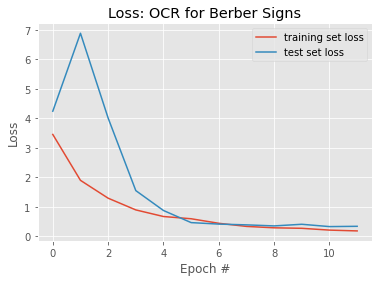

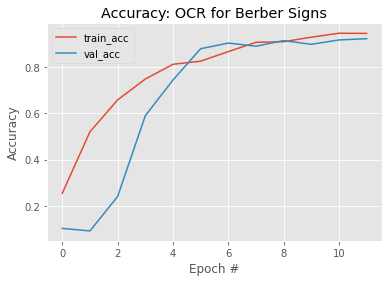

In [ ]:
# plot for training loss 
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="training set loss")
plt.plot(N, H.history["val_loss"], label="test set loss")
plt.title("Loss: OCR for Berber Signs")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()


# plot for training accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["accuracy"], label="train_acc") 
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Accuracy: OCR for Berber Signs")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("Accuracy_plot_256.png")
files.download("Accuracy_plot_256.png")

#### Confusion Matrix

12/12 [==============================] - 0s 31ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ploting Conf_Mat..................


<Figure size 432x288 with 0 Axes>

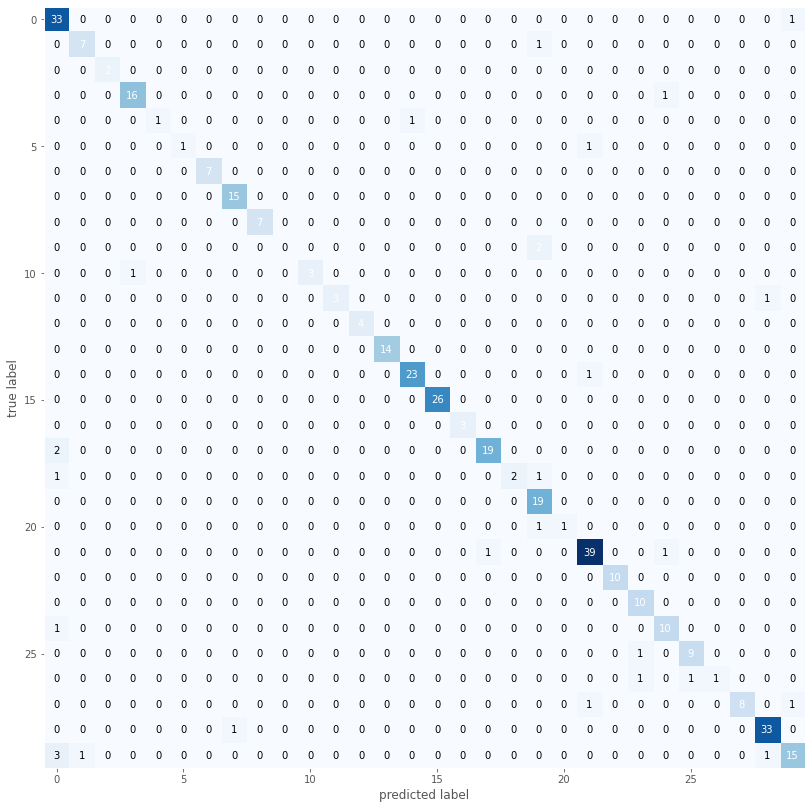

In [ ]:
# ploting confision matrix

y_pred = np.argmax(model.predict(x_test), axis=-1)
y_test_mat=np.argmax(y_test, axis=1)
mat = confusion_matrix(y_test_mat, y_pred)
plt.figure()
plot_confusion_matrix(conf_mat=mat, figsize=(14, 14))
plt.savefig("conf_mat.png")
files.download("conf_mat.png")
print("Ploting Conf_Mat..................")